In [77]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import (
    Binarizer,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, f_oneway, pearsonr
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

set_config(transform_output="pandas")

df = pd.read_csv("winequality-red.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [78]:
df.isna().value_counts()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH     sulphates  alcohol  quality
False          False             False        False           False      False                False                 False    False  False      False    False      1599
Name: count, dtype: int64

Aucune valeur manquante.

Le but de ce projet est de créer un modéle de régréssion qui permet de prédire la qualité d'un vin puis d'essayer de comprendre quels sont les variables qui sont les plus important pour décrire la qualité du vin. Pour cela on utilisera un modéle linéaire.
# I) Description des variables

Ce jeu de données est basée la publication https://people.stat.sc.edu/hoyen/STAT540/Exam/Wine.pdf. Sur cette publication il y a l'information pour les versions rouge et blanc du vihno verde. Notre jeu de données est seulement pour la version rouge du vhino verde.

1 - fixed acidity (g d’acide tartrique par dm³): la plupart des acides présents dans le vin sont fixes ou non volatils (ils ne s'évaporent pas facilement).

2 - volatile acidity (g d’acide acétique par dm³): la quantité d'acide acétique dans le vin, qui, à des niveaux trop élevés, peut donner un goût désagréable de vinaigre.

3 - citric acid (g par dm³): Présent en petites quantités, l'acide citrique peut ajouter de la « fraîcheur » et de la saveur aux vins.

4 - residual sugar (g par dm³): la quantité de sucre restante après l'arrêt de la fermentation, il est rare de trouver des vins contenant moins de 1 gramme/litre

5 - chlorides (g de chlorure de sodium par dm³): La quantité de sel dans le vin

6 - free sulfur dioxide (mg par dm³): La forme libre du SO2 existe en équilibre entre le SO2 moléculaire (sous forme de gaz dissous) et l'ion bisulfite.

7 - total sulfur dioxide (mg par dm³): quantité de formes libres et liées de S02 ; à faible concentration, le SO2 est généralement indétectable dans le vin

8 - density (g par cm³): La densité du vin est proche de celle de l'eau, en fonction du pourcentage d'alcool et de la teneur en sucre.

9 - pH : Décrit le degré d'acidité ou d'alcalinité d'un vin sur une échelle allant de 0 (très acide) à 14 (très alcalin)

10 - sulphates (g de sulfate de potassium par dm³): un additif pour le vin qui peut contribuer à augmenter les niveaux de dioxyde de soufre (SO2), qui agit comme antimicrobien et antioxydant.

11 - alcohol (pourcentage volumique, % vol): Le degrés d'alcool du vin.

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

La target quality est la seule variable discréte de ce jeu de données.

Les lignes sont différents vin rouge vhino verde portuguai.

On observe que toutes les concentrations sont exprimées avec des unités de concentration massique et en plus ils ne sont pas les mêmes. La premiére chose à faire est donc de convertir chaque concentration des deux différents type de S02 et la densité en g/dm3 (g/l) pour faciliter la normalisation. 

In [79]:
df["free sulfur dioxide"] *= 0.001
df["total sulfur dioxide"] *= 0.001
df["density"] *= 1000

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,0.025,0.067,996.80,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,0.015,0.054,997.00,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,0.017,0.060,998.00,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,0.032,0.044,994.90,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,0.039,0.051,995.12,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,0.029,0.040,995.74,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,0.032,0.044,995.47,3.57,0.71,10.2,5


In [80]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
493,8.7,0.690,0.31,3.0,0.086,0.0230,0.081,1000.20,3.48,0.74,11.6,6
354,6.1,0.210,0.40,1.4,0.066,0.0405,0.165,991.20,3.25,0.59,11.9,6
342,10.9,0.390,0.47,1.8,0.118,0.0060,0.014,998.20,3.30,0.75,9.8,6
834,8.8,0.685,0.26,1.6,0.088,0.0160,0.023,996.94,3.32,0.47,9.4,5
705,8.4,1.035,0.15,6.0,0.073,0.0110,0.054,999.00,3.37,0.49,9.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,9.1,0.600,0.00,1.9,0.058,0.0050,0.010,997.70,3.18,0.63,10.4,6
1294,8.2,0.635,0.10,2.1,0.073,0.0250,0.060,996.38,3.29,0.75,10.9,6
860,7.2,0.620,0.06,2.7,0.077,0.0150,0.085,997.46,3.51,0.54,9.5,5
1459,7.9,0.200,0.35,1.7,0.054,0.0070,0.015,994.58,3.32,0.80,11.9,7


# II) Analyse statistiques

## II.1) Analyse de la target

In [81]:
train_set["quality"].value_counts().sort_index()

quality
3      9
4     43
5    551
6    506
7    157
8     13
Name: count, dtype: int64

On voit que la plupart des vins ont des score de 5 et 6 qui correspond probablement à des vins de table classique ni mauvais ni exceptionnelle. On voit una augmentation puis une diminution du nombre de vin en fonction de la qualité. Il n'y a aucun vin en-dessous de 3 et au-dessus de 8. On voit qu'il y a moins de 30 vin pour les notes de 3 et 8. Pour simplifié la visualisation de l'évolution de chaque variable X, on va combiner la note 3 avec la 4 et 8 avec le 7. Regardons sur un graphique pour mieux voir la distribution.

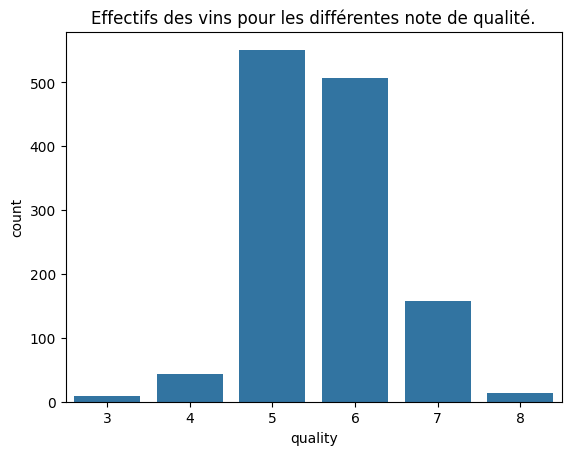

In [82]:
sns.countplot(data=train_set, x="quality")
plt.title("Effectifs des vins pour les différentes note de qualité.")
plt.show()

In [83]:
analyse_set = train_set.copy()
analyse_set["quality"].replace({3: 4, 8: 7}, inplace=True)
analyse_set["quality"].value_counts().sort_index()

/tmp/ipykernel_1288/2854978225.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  analyse_set["quality"].replace({3: 4, 8: 7}, inplace=True)


quality
4     52
5    551
6    506
7    170
Name: count, dtype: int64

On voit clairement que la qualité suit une loi normale. Pour la suite on va analyser toutes les variables en découpant chaque variable par type. Les variables d'acidité fixed acidity, volatile acidity, citric acid et pH. Les variables de concentrations en sucre et sel. Les variables de concentrations en molécule souffré qui contienne les variables free sulfur dioxide, total sulfur dioxide et sulphates. La variable de densité. On étudiera tous seul et en premier le pourcentage volumique en alcool car c'est l'élément centrale de toutes boisson alcoolisé.

## II.2) Le degré d'alcool

### II.2.1) Analyse univarié

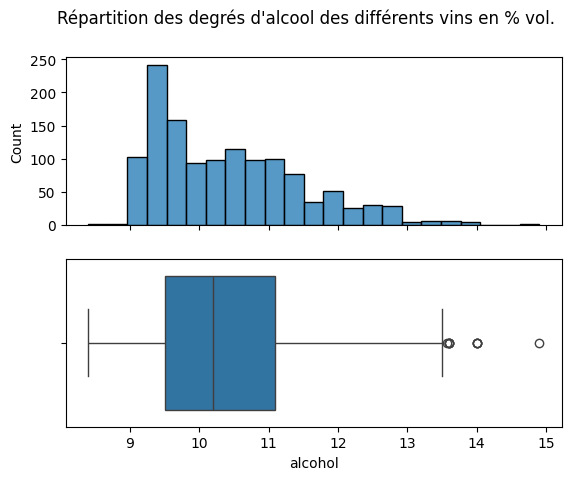

count    1279.000000
mean       10.418100
std         1.052694
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64

In [84]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des degrés d'alcool des différents vins en % vol.")
sns.histplot(data=analyse_set, x="alcohol", ax=ax[0])
sns.boxplot(data=analyse_set, x="alcohol", ax=ax[1])
plt.show()

analyse_set["alcohol"].describe()

Les vins rouges de type vhino verde portuguais de ce jeu de donnée ont en mopyenne un degrés d'alcool de 10.41 degrés qui est un degré plutôt normale. On voit que le minimum est de 8.4 qui est un vin trés peu alcooliser pour un vin. Le maximum à 14 degrés qui est un vin qui est considérée comme trés alcoolisé. On voit que l'alcool suit une loi normale et on observe des outliers à droite de la boxplot.

### II.2.2) Analyse multivarié

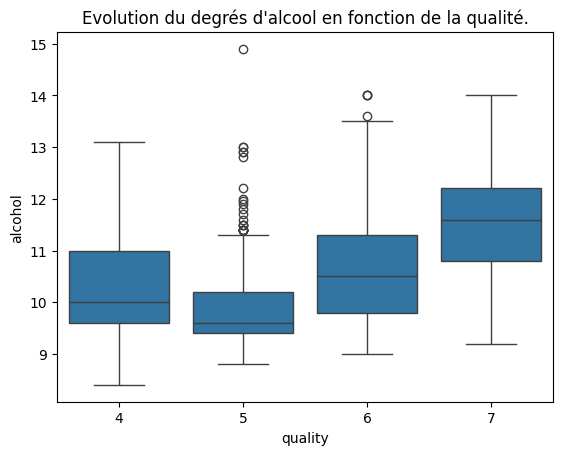

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,10.241346,0.948307,8.4,9.6,10.0,11.0,13.1
5,551.0,9.898548,0.732286,8.8,9.4,9.6,10.2,14.9
6,506.0,10.634157,1.022647,9.0,9.8,10.5,11.3,14.0
7,170.0,11.513039,1.001522,9.2,10.8,11.6,12.2,14.0


In [85]:
sns.boxplot(data=analyse_set, x="quality", y="alcohol")
plt.title("Evolution du degrés d'alcool en fonction de la qualité.")
plt.show()

analyse_set.groupby("quality")["alcohol"].describe()

On observe d'abords une diminution puis ensuite une augmentation des statistique de degré d'alcool. Pour tester cette évolution on va faire un test de ANOVA. Voici les conditions d'utilisation:

1) Tous les vins sont issues de la même population.

2) Le degrés d'alcool d'un vin ne dépends des autres.

3) Il y a plus de 3à points par groupes

4) Les écart-type sont assez similaires pour faire un test de ANOVA.

In [86]:
print("H0: Les degrés d'alcool en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["alcohol"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les degrés d'alcool en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


Comme on a rejeter H0, on peut dire avec un seuil alpha de 2% qu'il y a a bien une variation du degré d'alcool en fonction de la qualité.

## II.3) Analyse des variables d'acidité.

### II.3.1) Analyse univarié

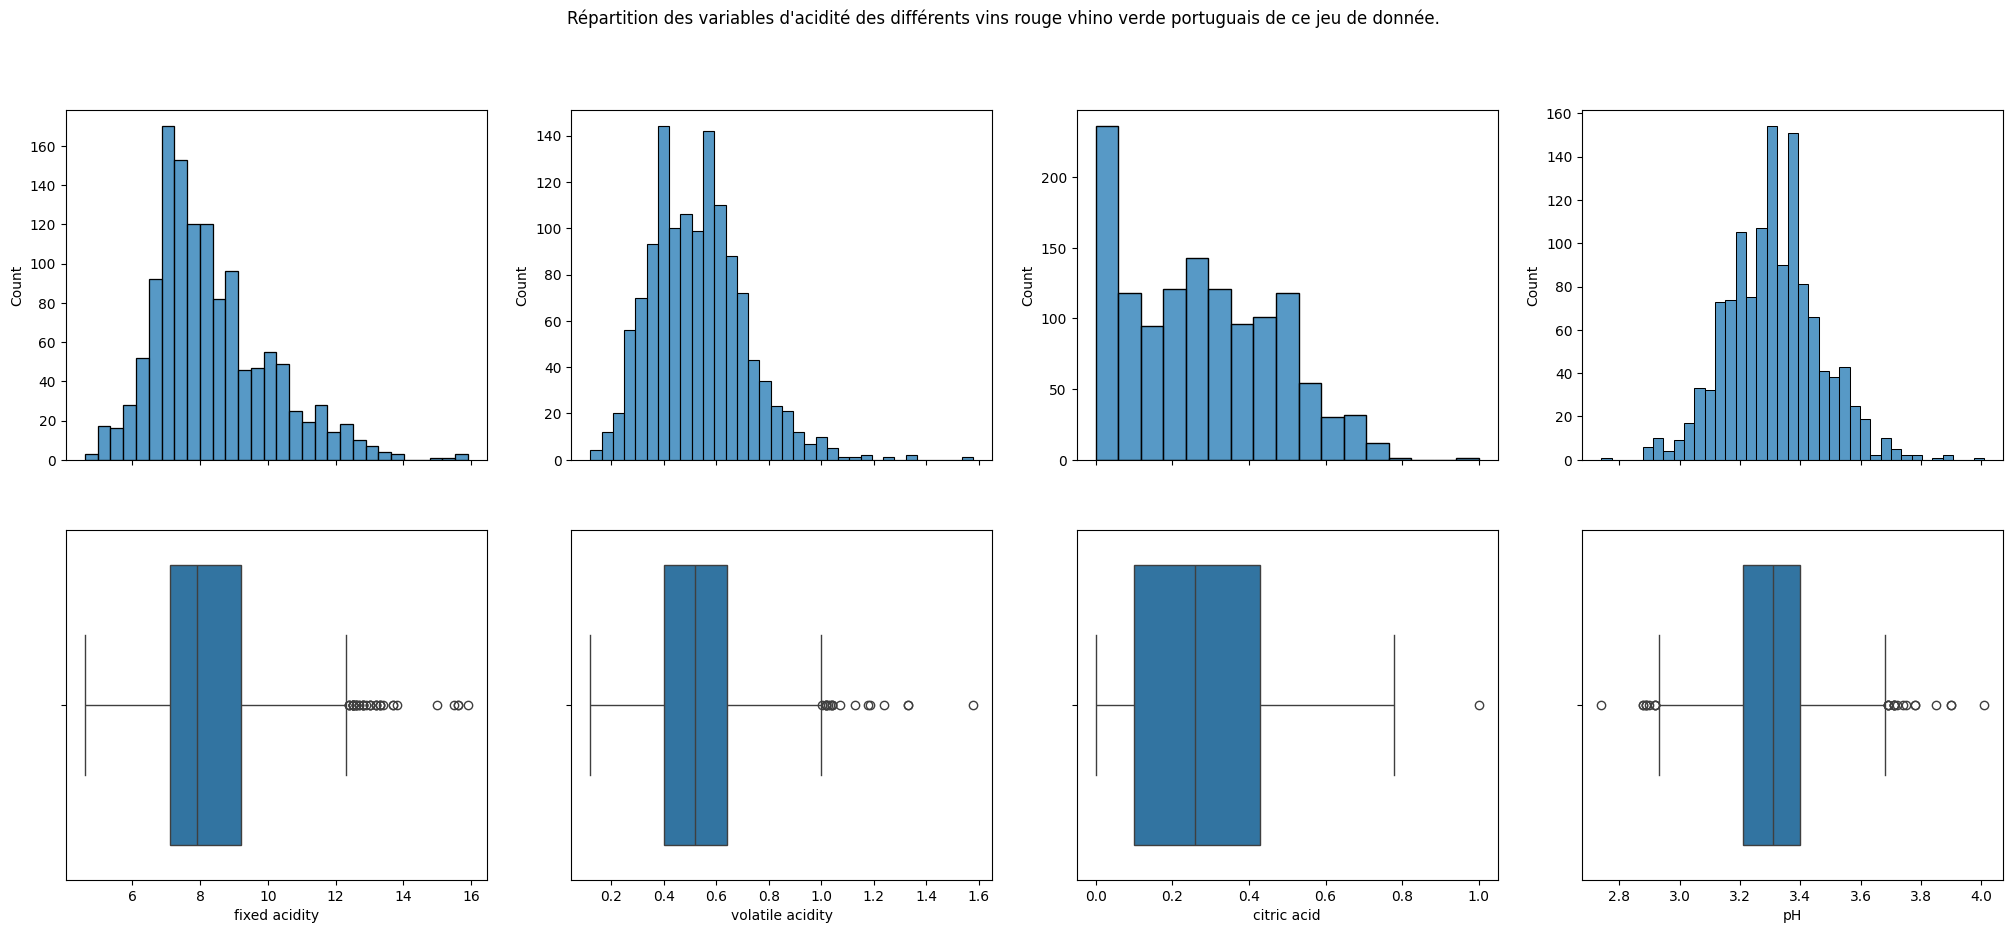

,fixed acidity,volatile acidity,citric acid,pH
count,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.323690,0.530559,0.272471,3.311650
std,1.724243,0.179275,0.195448,0.154016
min,4.600000,0.120000,0.000000,2.740000
25%,7.100000,0.400000,0.100000,3.210000
50%,7.900000,0.520000,0.260000,3.310000
75%,9.200000,0.640000,0.430000,3.400000
max,15.900000,1.580000,1.000000,4.010000


In [87]:
fig, ax = plt.subplots(2, 4, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables d'acidité des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.histplot(data=analyse_set, x="fixed acidity", ax=ax[0, 0])
sns.boxplot(data=analyse_set, x="fixed acidity", ax=ax[1, 0])
sns.histplot(data=analyse_set, x="volatile acidity", ax=ax[0, 1])
sns.boxplot(data=analyse_set, x="volatile acidity", ax=ax[1, 1])
sns.histplot(data=analyse_set, x="citric acid", ax=ax[0, 2])
sns.boxplot(data=analyse_set, x="citric acid", ax=ax[1, 2])
sns.histplot(data=analyse_set, x="pH", ax=ax[0, 3])
sns.boxplot(data=analyse_set, x="pH", ax=ax[1, 3])
plt.show()
analyse_set[["fixed acidity", "volatile acidity", "citric acid", "pH"]].describe()

Les vins vhino verde portuguais rouge de ce jeu de donnée ont en moyenne une acidité fixe, une acidité volatile, une concentration en acide citrique et un pH respectivement égale à 8.323690 g/dm3, 0.530559 g/dm3, 0.272471 g/dm3 et 3.311650. On peut dire que tous les vins sont acides car elles sont toutes en-dessous de 7. On observe que l'acidité fixe, volatile et le pH suivent une loi nomale et la concentration en acide citrique ne suit pas une loi normale. On observe des outliers à droite de chaque boxplot et aussi à gauche pour le pH.

### II.3.2) Analyse multivarié avec la target

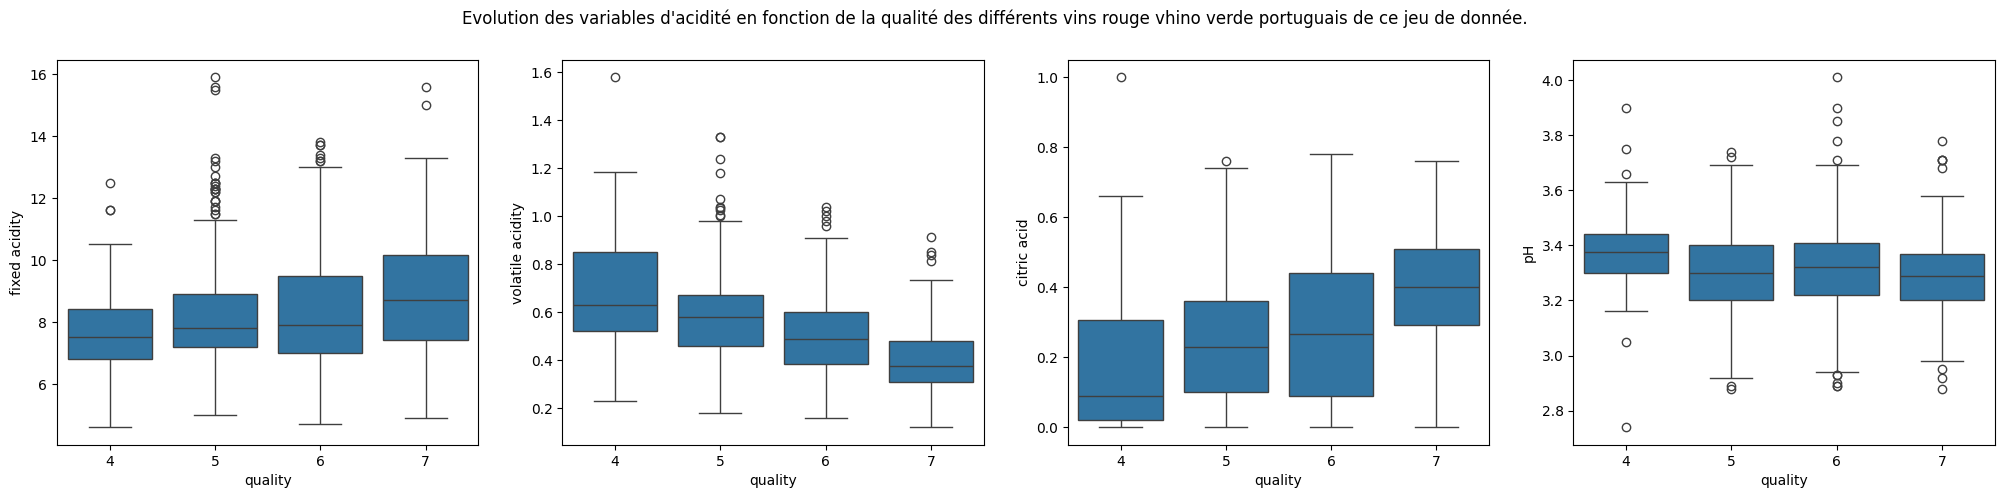

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,7.873077,1.672748,4.6,6.8,7.5,8.425,12.5
5,551.0,8.187296,1.526143,5.0,7.2,7.8,8.900,15.9
6,506.0,8.347036,1.807005,4.7,7.0,7.9,9.475,13.8
7,170.0,8.834118,1.978377,4.9,7.4,8.7,10.175,15.6


In [88]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Evolution des variables d'acidité en fonction de la qualité des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.boxplot(data=analyse_set, x="quality", y="fixed acidity", ax=ax[0])
sns.boxplot(data=analyse_set, x="quality", y="volatile acidity", ax=ax[1])
sns.boxplot(data=analyse_set, x="quality", y="citric acid", ax=ax[2])
sns.boxplot(data=analyse_set, x="quality", y="pH", ax=ax[3])
plt.show()
analyse_set.groupby("quality")["fixed acidity"].describe()

In [89]:
analyse_set.groupby("quality")["volatile acidity"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.695481,0.255159,0.23,0.5200,0.630,0.8525,1.580
5,551.0,0.580163,0.168530,0.18,0.4600,0.580,0.6700,1.330
6,506.0,0.500603,0.159640,0.16,0.3825,0.490,0.6000,1.040
7,170.0,0.408500,0.144032,0.12,0.3100,0.375,0.4800,0.915


In [90]:
analyse_set.groupby("quality")["citric acid"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.189038,0.215536,0.0,0.0200,0.090,0.305,1.00
5,551.0,0.245989,0.178087,0.0,0.1000,0.230,0.360,0.76
6,506.0,0.275277,0.196922,0.0,0.0900,0.265,0.440,0.78
7,170.0,0.375471,0.201591,0.0,0.2925,0.400,0.510,0.76


In [91]:
analyse_set.groupby("quality")["pH"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,3.375000,0.177339,2.74,3.3000,3.375,3.4425,3.90
5,551.0,3.303702,0.149930,2.88,3.2000,3.300,3.4000,3.74
6,506.0,3.320316,0.154236,2.89,3.2200,3.320,3.4100,4.01
7,170.0,3.292235,0.153634,2.88,3.2025,3.290,3.3700,3.78


On voit clairement que l'acidité fixe et la concentration en acide citrique augmente en fonction de la qualité. Effectivement comme l'acide citrique ajoute de la fraicheur cela peut améliorer la qualité du vin. Pour l'acide tartrique comme on peut le citer dans le site https://chateauberne-vin.com/pages/definition/acide-tartrique#:~:text=Les%20vins%20contenant%20un%20niveau,et%20autres%20micro%2Dorganismes%20n%C3%A9fastes: "Les vins contenant un niveau optimal d’*acide tartrique* présentent plusieurs avantages distincts. Sur le plan gustatif, ils offrent une fraîcheur et une vivacité inégalées. En termes de stabilité, cet acide protège contre la croissance indésirable de bactéries et autres micro-organismes néfastes. Plus précisément, les caractéristiques affectées par l’acide tartrique incluent :

Acidité : Contribue à l’équilibre global.
Saveur : Améliore le profil aromatique.
Stabilité : Prévient la dégradation prématurée."

Donc c'est assez logique que ces deux variables sont importantes pour notre modéle. On observe une diminution de la qualité avec l'acidité volatile qui correspond en fait à la concentration en acide acétique qui donne un gout de vinaigre qui est désagréable. Donc c'est tout à fait logique que la qualité diminue avec l'acidité volatile. On ne voit pas de variation pour le pH. On va donc tester les variations avec un test de ANOVA. Condition:

1) Tous les vins issues de la même population

2) Tous les variables d'acidité d'un vin ne dépends des autres

3) On a bien plus de 30 vins par groupes de qualité

4) Les écart-types sont assez similaires pour faire des test de Anova pour les quatres variables d'acidité.

In [92]:
print("H0: Les acidité fixe en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["fixed acidity"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les acidité fixe en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [93]:
print("H0: Les acidité volatile en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(
    *analyse_set.groupby("quality")["volatile acidity"].apply(list)
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les acidité volatile en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [94]:
print(
    "H0: Les concentration massique en acide citrique en moyenne ne varie en fonction de la qualité."
)

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["citric acid"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les concentration massique en acide citrique en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [95]:
print("H0: Les pH en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["pH"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les pH en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


Comme on a rejeter H0 pour les quatres variables, on peut dire qu'il y a bien une évolution des quatres variables d'acidité en fonction de la qualité. On va maintenant visualiser les relations entre les variables d'acidité entre-eux en affichant la qualité avec hue.

### II.3.3) Analyse desvariables d'acidité entre-eux.

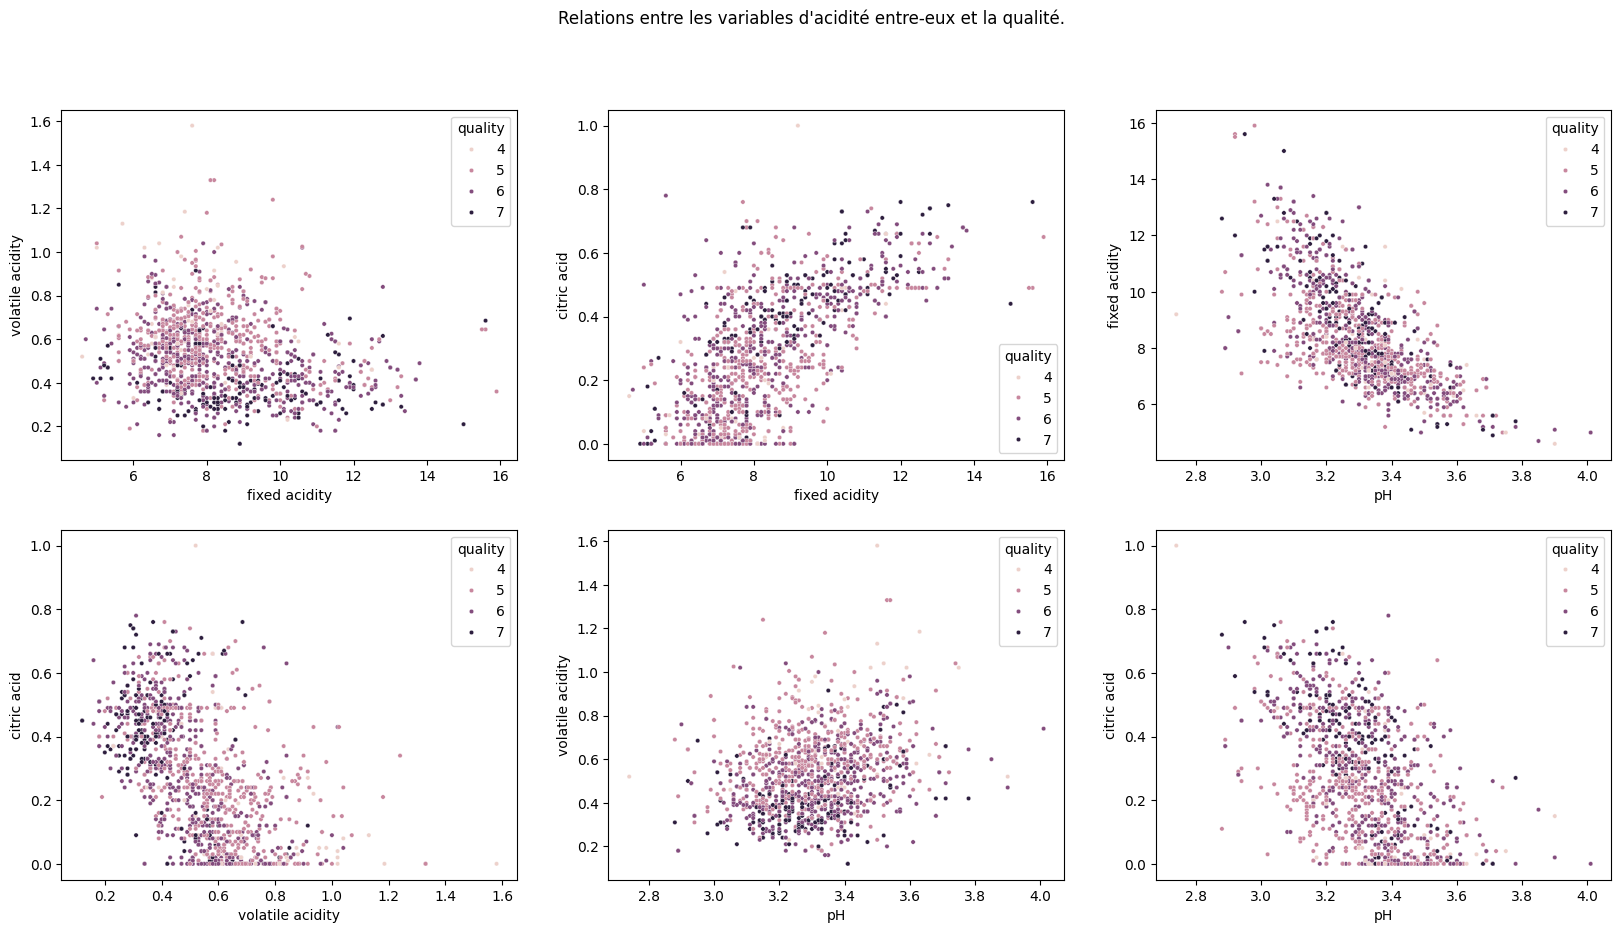

In [96]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 10)
plt.suptitle("Relations entre les variables d'acidité entre-eux et la qualité.")
sns.scatterplot(
    data=analyse_set,
    x="fixed acidity",
    y="volatile acidity",
    hue="quality",
    ax=ax[0, 0],
    s=10,
)
sns.scatterplot(
    data=analyse_set,
    x="fixed acidity",
    y="citric acid",
    hue="quality",
    ax=ax[0, 1],
    s=10,
)
sns.scatterplot(
    data=analyse_set, x="pH", y="fixed acidity", hue="quality", ax=ax[0, 2], s=10
)
sns.scatterplot(
    data=analyse_set,
    x="volatile acidity",
    y="citric acid",
    hue="quality",
    ax=ax[1, 0],
    s=10,
)
sns.scatterplot(
    data=analyse_set, x="pH", y="volatile acidity", hue="quality", ax=ax[1, 1], s=10
)
sns.scatterplot(
    data=analyse_set, x="pH", y="citric acid", hue="quality", ax=ax[1, 2], s=10
)
plt.show()

Je le rappel que l'acidité fixe est la concenttration en acide tartrique et l'acidité volatile la concentration en acide acétique. On voit qu'il y a des relations entre la concentration de l'acide tartrique avec l'acide citrique. Il y a aussi une relation entre l'acide acétique et l'acide citrique. On a aussi une relation entre le pH et les acides tartrique et citrique mais pas avec l'acide acétique. Les relations entre les variables d'acidité est dues à la chimie des acides. On va essayer de calculer les corrélations de pearson et les valeurs de Vif pour diagnostiquer le risque de multicolinéarité.

In [97]:
print(pearsonr(analyse_set["volatile acidity"], analyse_set["fixed acidity"]))
print(pearsonr(analyse_set["citric acid"], analyse_set["fixed acidity"]))
print(pearsonr(analyse_set["fixed acidity"], analyse_set["pH"]))
print(pearsonr(analyse_set["citric acid"], analyse_set["volatile acidity"]))
print(pearsonr(analyse_set["volatile acidity"], analyse_set["pH"]))
print(pearsonr(analyse_set["citric acid"], analyse_set["pH"]))


def compute_vif(df: pd.DataFrame) -> pd.DataFrame:
    Xc = df.select_dtypes(include=[np.number]).dropna()
    vifs = [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    out = pd.DataFrame({"variable": Xc.columns, "VIF": vifs})
    return out[out["variable"] != "const"].sort_values("VIF", ascending=False)


compute_vif(analyse_set[["volatile acidity", "fixed acidity", "citric acid", "pH"]])

PearsonRResult(statistic=np.float64(-0.24253250880428218), pvalue=np.float64(1.4064831859684533e-18))
PearsonRResult(statistic=np.float64(0.6691965107449729), pvalue=np.float64(6.907229646426074e-167))
PearsonRResult(statistic=np.float64(-0.6761970153404481), pvalue=np.float64(1.1591992748707156e-171))
PearsonRResult(statistic=np.float64(-0.545491017552263), pvalue=np.float64(4.688051603574247e-100))
PearsonRResult(statistic=np.float64(0.2179030879077732), pvalue=np.float64(3.269913897234261e-15))
PearsonRResult(statistic=np.float64(-0.540161287815564), pvalue=np.float64(8.913894949203053e-98))


,variable,VIF
1,fixed acidity,38.941535
3,pH,31.628974
0,volatile acidity,14.280024
2,citric acid,7.453908


On voit que le pH à de forte corrélation avec la concentration en acide tartrique et citrique. Il y a aussi des fortes relations entre la concentration en acide citrique et acide tartrique et aussi entre l'acide citrique et l'acide acétique. Le pH à une petite corrélation mais éxistante avec l'acide acétique. Il y aussi une relation avec une petite corrélation mais tous de même existante entre la concentration en acide acétique et tarttrique. Même si le pH dépends principalement des concentrations en acide tartrique et citrique, on à quand même une petite influence de l'acide acétique. En plus on à des valeurs de VIF qui sont tous supérieur à 5. Il y a donc risque de colinéarité. On va donc sélectionner les variables les plus intéréssante qui sont la concentration en acide acétique et en acide citrique car l'évolution de la qualité au niveau des boxplot et des graphique est beaucoup plus forte pour ces deux variables et en plus une corrélation de -0.545491017552263 ne va pas être problématique pour le modéle.